2022/3/21

This code is for eliminating outlier and saving dataframe for correlation analysis.

In [1]:
import os, sys
import cv2
import copy
import math
import collections
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import interpolate
import statsmodels.api as sm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from math import factorial

In [2]:
#resolution
px_x10=0.215433 #um/pixel

#define func
def flatten_list(l):
    for el in l:
        if isinstance(el, list):
            yield from flatten_list(el)
        else:
            yield el
            

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
        
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [3]:
#set path
current_path=os.getcwd()
npz_path=os.path.join(current_path, "npz_file")
excel_file_path=os.path.join(current_path, "excel_file")
save_path_1=os.path.join(current_path, "fig_save", "cross-correlation")

#create folders
if os.path.exists(save_path_1)==False:
    os.makedirs(save_path_1)

if os.path.exists(excel_file_path)==False:
    os.makedirs(excel_file_path)


files=os.listdir(npz_path)
mfa_file=[i for i in files if "MFA_distributions_cell_by_cell_layer_by_layerx40.npz" in i]
radial_file=[i for i in files if "radial_file_based_anatomical_parameter_x40.npz" in i]
plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["mathtext.fontset"]="stix"

npz_mfa_file=np.load(os.path.join(npz_path, mfa_file[0]), allow_pickle=True)
npz_radial_file=np.load(os.path.join(npz_path, radial_file[0]), allow_pickle=True)

In [4]:
#load data
#MFA
MFA_S2=npz_mfa_file["MFA_S2"]
angle_S2=npz_mfa_file["angle_S2"]
MFA_minor=npz_mfa_file["MFA_minor"]
angle_minor=npz_mfa_file["angle_minor"]
MFA_S2_rad=npz_mfa_file["MFA_S2_rad"]
MFA_S2_tan=npz_mfa_file["MFA_S2_tan"]
MFA_minor_rad=npz_mfa_file["MFA_minor_rad"]
MFA_minor_tan=npz_mfa_file["MFA_minor_tan"]

mfa_data_list=[MFA_S2, MFA_S2_rad, MFA_S2_tan]

#MFA_hist
MFA_S2_hist=npz_mfa_file["MFA_S2_hist"]
MFA_S2_rad_hist=npz_mfa_file["MFA_S2_rad_hist"]
MFA_S2_tan_hist=npz_mfa_file["MFA_S2_tan_hist"]
MFA_bins=npz_mfa_file["MFA_bins"]

#anatomy
cell_area=npz_radial_file["cell_area"]
cell_perimeter=npz_radial_file["cell_perimeter"]
cell_height=npz_radial_file["cell_height"]
cell_width=npz_radial_file["cell_width"]
twall_thickness=npz_radial_file["twall_thickness"]
cellwall_occupancy=npz_radial_file["cellwall_occupancy"]
cell_circle_level=npz_radial_file["cell_circle_level"]
cellwall_area=npz_radial_file["cellwall_area"]
cell_cx=npz_radial_file["cell_cx"]
cell_cy=npz_radial_file["cell_cy"]

lumen_area=npz_radial_file["lumen_area"]
lumen_perimeter=npz_radial_file["lumen_perimeter"]
lumen_height=npz_radial_file["lumen_height"]
lumen_width=npz_radial_file["lumen_width"]
lumen_circle_level=npz_radial_file["lumen_circle_level"]

In [5]:
#prepare columns of dateframe 
#for mfa
mfa_name_list=["MFA of S$_{2}$ layer", "MFA of radial S$_{2}$ layer", "MFA of tangential S$_{2}$ layer"]
mfa_stat_list=["Mean ", "Std ", "Ste "]

mfa_stat_list_dup=np.tile(mfa_stat_list, len(mfa_name_list))
mfa_name_list_dup=np.repeat(mfa_name_list, 3)
mfa_frame_name_list=[mfa_stat_list_dup[i]+mfa_name_list_dup[i] for i in range(len(mfa_name_list_dup))]
mfa_frame_name_list=mfa_frame_name_list+["Cell_cx"]


#for anatomy
anatomy_name_list=["Cell area", "Cell perimeter", "Cell circle level", "Lumen area", "Lumen perimeter", "Lumen circle level", 
           "Cell wall area", "Cell wall occupancy", "Cell radial diameter", "Cell tangential diameter",
           "Lumen radial diameter", "Lumen tangential diameter", 
           "Tangential wall thickness", "Cell_cx"]

anatomy_unit_list=["($\u03bc$m$^{2}$)", "($\u03bc$m)", "", "($\u03bc$m$^{2}$)", "($\u03bc$m)", "", 
           "($\u03bc$m$^{2}$)", "%", "($\u03bc$m)", "($\u03bc$m)", "($\u03bc$m)", "($\u03bc$m)", 
           "($\u03bc$m)", ""]

anatomy_parameter_list=[cell_area, cell_perimeter, cell_circle_level, lumen_area, lumen_perimeter, lumen_circle_level, 
                cellwall_area, cellwall_occupancy, cell_width, cell_height, lumen_width, lumen_height, 
                twall_thickness, cell_cx]
anatomy_scaling_list=[px_x10**2, px_x10, 1, px_x10**2, px_x10, 1, px_x10**2, 1, px_x10, px_x10, px_x10, px_x10, px_x10, 1]
anatomy_param_No_list=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "extra"]

**Dataframe of anatomical parameters**

In [6]:
anatomy_parameter_list=[list(flatten_list(i)) for i in anatomy_parameter_list]
radial_file_No_list=[list(np.ones((len(cell_area[i])), dtype=int)*i) for i in range(len(cell_area))]
radial_file_No_list=list(flatten_list(radial_file_No_list))
anatomy_parameter_list=[np.asarray(anatomy_parameter_list[i])*anatomy_scaling_list[i] for i 
                           in range(len(anatomy_scaling_list))]

In [7]:
df_anatomy=pd.DataFrame(anatomy_parameter_list, index=anatomy_name_list, columns=radial_file_No_list).T

#get max and min value
max_vals=df_anatomy.max()
min_vals=df_anatomy.min()

df_anatomy=df_anatomy.iloc[::-1]
df_anatomy

,Cell area,Cell perimeter,Cell circle level,Lumen area,Lumen perimeter,Lumen circle level,Cell wall area,Cell wall occupancy,Cell radial diameter,Cell tangential diameter,Lumen radial diameter,Lumen tangential diameter,Tangential wall thickness,Cell_cx
17,1001.812789,125.266315,0.802283,721.766537,105.206767,0.819444,280.046252,27.953951,31.848831,33.072955,26.888731,27.758074,2.425616,4285.0
17,1264.361951,141.822947,0.789929,939.319869,119.391009,0.828095,325.042082,25.707993,37.006004,36.459471,31.749438,31.048284,2.480396,4124.0
17,1192.725990,137.252923,0.795623,879.982923,115.534868,0.828434,312.743067,26.220865,35.185595,35.608250,30.086047,30.405054,2.585295,3954.0
17,1015.225677,126.250530,0.800398,737.059086,106.182013,0.821505,278.166591,27.399483,32.383497,33.295737,27.631624,27.840227,2.364505,3798.0
17,897.062310,121.332533,0.765734,657.370751,116.023260,0.613663,239.691559,26.719611,27.913692,33.885816,23.214005,29.749088,1.952166,3655.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,412.063415,84.981432,0.717011,200.149065,59.412489,0.712538,211.914350,51.427606,16.183806,26.275132,10.442516,20.448182,2.942007,1140.0
0,343.513810,81.386655,0.651700,104.425599,49.197902,0.542155,239.088211,69.600757,12.984326,27.418745,6.066871,17.730136,3.399481,1072.0
0,351.102071,85.987299,0.596726,86.789276,45.498579,0.526842,264.312795,75.280899,12.984326,28.334336,5.401213,17.419297,4.362618,1011.0
0,268.675464,79.493689,0.534284,38.289386,38.321707,0.327641,230.386078,85.748834,9.495949,29.150778,2.706377,11.956532,3.790898,960.0


In [8]:
#drop data of radial file No 8 and 17
drop_list=[8, 17]

for i in range(len(drop_list)):
    df_anatomy=df_anatomy.drop(index=drop_list[i])

#drop lumen height
df_anatomy=df_anatomy.drop("Lumen tangential diameter", axis=1)
df_anatomy

,Cell area,Cell perimeter,Cell circle level,Lumen area,Lumen perimeter,Lumen circle level,Cell wall area,Cell wall occupancy,Cell radial diameter,Cell tangential diameter,Lumen radial diameter,Tangential wall thickness,Cell_cx
16,1549.861540,161.559889,0.746166,1133.040959,136.582345,0.763249,416.820581,26.894053,42.386443,38.180883,36.899756,2.606044,4312.0
16,1347.600757,149.212625,0.760606,963.476991,126.694079,0.754290,384.123766,28.504271,39.235735,36.208821,33.691083,2.711535,4124.0
16,1225.631657,141.839346,0.765555,868.171227,120.013030,0.757458,357.460429,29.165404,39.065184,32.168648,33.803831,2.616075,3944.0
16,1211.870683,140.599020,0.770374,871.930549,132.304306,0.625956,339.940134,28.050859,38.824944,32.553232,33.202440,2.610240,3765.0
16,1145.850499,135.424913,0.785128,810.876382,124.391899,0.658537,334.974117,29.233667,34.703285,35.227010,28.870220,2.703572,3594.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,412.063415,84.981432,0.717011,200.149065,59.412489,0.712538,211.914350,51.427606,16.183806,26.275132,10.442516,2.942007,1140.0
0,343.513810,81.386655,0.651700,104.425599,49.197902,0.542155,239.088211,69.600757,12.984326,27.418745,6.066871,3.399481,1072.0
0,351.102071,85.987299,0.596726,86.789276,45.498579,0.526842,264.312795,75.280899,12.984326,28.334336,5.401213,4.362618,1011.0
0,268.675464,79.493689,0.534284,38.289386,38.321707,0.327641,230.386078,85.748834,9.495949,29.150778,2.706377,3.790898,960.0


In [9]:
#update radial_file_No_list and name_list
anatomy_param_index=[i for i in range(len(anatomy_name_list)) if "Lumen tangential diameter" in anatomy_name_list[i]][0]
anatomy_param_No_list.pop(anatomy_param_index)
radial_file_No_list=df_anatomy.index.values
anatomy_name_list=df_anatomy.columns.values

In [10]:
#radial file normalization
#get mean cell number of radial cell files
c = collections.Counter(radial_file_No_list)
cell_number=np.asarray(list(c.values()))
mean_cell_number=math.ceil(cell_number.mean())

#get number of radial file No
radial_file_No=list(c.keys())

#make No list
radial_file_norm_No_list=[list(np.ones((mean_cell_number), dtype=int)*i) for i in radial_file_No]
radial_file_norm_No_list=list(flatten_list(radial_file_norm_No_list))

**Radial file normalization applied to anatomical parameters for detecting outliers**

In [11]:
#create interpolation function
#x: cell_cx, y:anatomical parameter

df_anatomy_norm=pd.DataFrame(index=anatomy_name_list, columns=radial_file_norm_No_list).T
for i, No in enumerate(radial_file_No):
    
    #get target part
    target_frame=df_anatomy[df_anatomy.index==No]
    
    #calculate x beforehand
    x=target_frame["Cell_cx"].values
    normed_x=np.linspace(x[0], x[-1], mean_cell_number)
    
    for j in tqdm(range(len(df_anatomy.columns)-1)):
        #get y values
        y=target_frame.iloc[:, j].values

        #create function for linear interpolation.
        f = interpolate.interp1d(x, y)
        
        #predict normed y values
        normed_y=f(normed_x)
        
        #normed values are saved in dataframe
        df_anatomy_norm.iloc[:, j][i*mean_cell_number:(i+1)*mean_cell_number]=normed_y
        
        if j==0:
            df_anatomy_norm["Cell_cx"][i*mean_cell_number:(i+1)*mean_cell_number]=normed_x
        else:
            pass

100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 2975.04it/s]


In [12]:
#add new columns
new_index=np.tile(np.arange(0, mean_cell_number), len(radial_file_No))
df_anatomy_norm["new_index"]=new_index
df_anatomy_norm=df_anatomy_norm.astype({"new_index": int})

**Outlier detection based on tangential wall thickness**<br>
if tangential wall thickness deviates from three sigma, it is regarded as an outlier. <br>

In [13]:
#outlier detection by tangential wall thickness
new_cx=np.sort(df_anatomy_norm["new_index"].values)
new_ind=np.argsort(df_anatomy_norm["new_index"].values)

new_frame=pd.DataFrame(np.vstack((df_anatomy_norm["Tangential wall thickness"].values[new_ind], 
                                 df_anatomy_norm.index.values[new_ind])), columns=new_cx).T
mean_trend=np.array([np.median(new_frame[new_frame.index==i].iloc[:, 0].values) for i in np.unique(new_frame.index)])
std_trend=np.array([new_frame[new_frame.index==i].iloc[:, 0].values.std() for i in np.unique(new_frame.index)])

std_bottom=pd.DataFrame(np.repeat(mean_trend-std_trend*3, len(np.unique(radial_file_norm_No_list))), index=new_cx)
std_upper=pd.DataFrame(np.repeat(mean_trend+std_trend*3, len(np.unique(radial_file_norm_No_list))), index=new_cx)

ind_1=list(np.where((new_frame-std_bottom)<0)[0])
ind_2=list(np.where((new_frame-std_upper)>0)[0])
ind_outlier=ind_1+ind_2

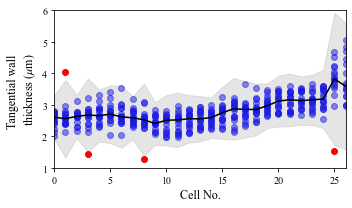

In [37]:
#result visalization, Fig,S2
plt.figure(figsize=(5, 3))
plt.scatter(df_anatomy_norm["new_index"].values, 
            df_anatomy_norm["Tangential wall thickness"].values, c="blue", alpha=0.5)
plt.plot(np.arange(0, mean_cell_number), mean_trend, c="black")
plt.fill_between(np.arange(0, mean_cell_number),
                    mean_trend-std_trend*3,
                    mean_trend+std_trend*3,
                    alpha=0.2, color="grey")
plt.scatter(new_frame.iloc[ind_outlier].index.values, 
            new_frame.iloc[ind_outlier].iloc[:, 0].values, c="red")
plt.ylim(1, 6)
plt.xlim(0, 26)
plt.ylabel("Tangential wall \nthickness ($\u03bc$m)", size=12)
plt.xlabel("Cell No.", size=12)
plt.tight_layout()
plt.savefig(os.path.join(save_path_1, "Tangential_wall_trend_outlier_detection.png"), dpi=600)
plt.show()
plt.close()

**This result is finally reflected to original dataframe**<br>
Outliers are replaced by Nan

In [15]:
#get function of mean and std 
x=np.unique(df_anatomy_norm["new_index"].values)/np.max(df_anatomy_norm["new_index"].values)
y_mean=mean_trend
y_std_upper=mean_trend+std_trend*3
y_std_bottom=mean_trend-std_trend*3

f_mean=interpolate.interp1d(x, y_mean)
f_std_upper=interpolate.interp1d(x, y_std_upper)
f_std_bottom=interpolate.interp1d(x, y_std_bottom)

#get outlier index in normalized frame
outlier_radial_file_No=new_frame.iloc[ind_outlier].iloc[:, 1].values
outlier_cell_No=new_frame.iloc[ind_outlier].index.values

In [16]:
#add new columns to df_anatomy
cell_No_index=[list(np.arange(0, cell_number[i])) for i in range(len(cell_number))]
cell_No_index=list(flatten_list(cell_No_index))
df_anatomy["new_index"]=cell_No_index

In [17]:
#get outliers in original database and they are replaed by Nan
scanning_range=3

df_outliers=pd.DataFrame(columns=df_anatomy.columns.values)
a=[]
for i in range(len(outlier_radial_file_No)):
    
    target_frame=df_anatomy[df_anatomy.index==outlier_radial_file_No[i]]
    target_frame_cell=target_frame.iloc[max(0, outlier_cell_No[i]-scanning_range):outlier_cell_No[i]+scanning_range+1]

    #get cell index and normalized
    cx=target_frame["new_index"]/np.max(target_frame["new_index"])
    #get tangential wall thickness
    tan=target_frame["Tangential wall thickness"]
    
    #get target cell region
    target_cx=cx[outlier_cell_No[i]-scanning_range:outlier_cell_No[i]+scanning_range+1]
    target_tan=tan[outlier_cell_No[i]-scanning_range:outlier_cell_No[i]+scanning_range+1]

    #predict upper and lower boundary
    bottom_bound=f_std_bottom(target_cx)
    upper_bound=f_std_upper(target_cx)
    
    #get outliers index
    outliers=list(np.where((target_tan-bottom_bound<0) | (target_tan-upper_bound>0))[0])
    
    if len(outliers)>0:
        #create temp dataframe for outliers
        target_frame_cell.iloc[outliers, :12]=np.nan
        outliers_frame=target_frame_cell.iloc[outliers]
        
        #save outliers
        df_outliers=pd.concat([df_outliers, outliers_frame], axis=0)
    else:
        pass

C:\Users\yusukekita\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\yusukekita\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\yusukekita\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

**Get outlier index in original dataframe as outlier_ind_ori**

In [18]:
#get index of outliers
outlier_cell_No_ori=list(df_outliers["new_index"].values)
outlier_radial_file_No_ori=list(df_outliers.index.values)

#get index of original dataframe
outlier_ind_ori=[list(set(list(np.where(df_anatomy.index==outlier_radial_file_No_ori[i])[0])) 
                      & set(list(np.where(df_anatomy["new_index"]==outlier_cell_No_ori[i])[0])))
                 for i in range(len(outlier_cell_No_ori))]
outlier_ind_ori=list(flatten_list(outlier_ind_ori))

#replace outliers by nan
df_anatomy.iloc[outlier_ind_ori, :12]=np.nan

**Dataframe of mean and standard deviation of MFA**

In [19]:
#create matrix for containing results
radial_file_No_list=[list(np.ones((len(cell_cx[i])), dtype=int)*i) for i in range(len(cell_cx))]
radial_file_No_list=list(flatten_list(radial_file_No_list))

mfa_save_matrix=np.zeros((len(radial_file_No_list), len(mfa_frame_name_list)))

for i in tqdm(range(len(mfa_data_list))):
    target_file_list=mfa_data_list[i]
    temp_mean_list=[]
    temp_std_list=[]
    temp_ste_list=[]
    
    for j in range(len(target_file_list)):
        target_file_list_mean=[np.mean(target_file_list[j][k]) for k in range(len(target_file_list[j]))]
        target_file_list_std=[np.std(target_file_list[j][k]) for k in range(len(target_file_list[j]))]
        target_file_list_ste=[np.std(target_file_list[j][k])/np.sqrt(len(target_file_list[j])) 
                              for k in range(len(target_file_list[j]))]
                
        temp_mean_list.extend(target_file_list_mean)
        temp_std_list.extend(target_file_list_std)
        temp_ste_list.extend(target_file_list_ste)
    
    #save the result
    mfa_save_matrix[:, i*3]=temp_mean_list
    mfa_save_matrix[:, i*3+1]=temp_std_list
    mfa_save_matrix[:, i*3+2]=temp_ste_list
    

#get cell cx
cell_cx_norm=[cell_cx[i] for i in range(len(cell_cx))]
cell_cx_norm_flatten=list(flatten_list(cell_cx_norm))
mfa_save_matrix[:, -1]=cell_cx_norm_flatten

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 30.97it/s]


In [20]:
mfa_summary_frame=pd.DataFrame(mfa_save_matrix, index=radial_file_No_list, columns=mfa_frame_name_list)[::-1]

#drop data of radial file No 8 and 17
drop_list=[8, 17]

for i in range(len(drop_list)):
    mfa_summary_frame=mfa_summary_frame.drop(index=drop_list[i])

mfa_summary_frame

,Mean MFA of S$_{2}$ layer,Std MFA of S$_{2}$ layer,Ste MFA of S$_{2}$ layer,Mean MFA of radial S$_{2}$ layer,Std MFA of radial S$_{2}$ layer,Ste MFA of radial S$_{2}$ layer,Mean MFA of tangential S$_{2}$ layer,Std MFA of tangential S$_{2}$ layer,Ste MFA of tangential S$_{2}$ layer,Cell_cx
16,17.904321,4.866015,0.973203,17.467428,5.717607,1.143521,18.503027,3.272160,0.654432,4312.0
16,23.165261,4.947856,0.989571,24.105721,6.018015,1.203603,22.052985,2.884250,0.576850,4124.0
16,17.293576,5.765476,1.153095,15.541897,5.983463,1.196693,20.942906,2.862691,0.572538,3944.0
16,15.716894,5.273442,1.054688,14.137445,6.108575,1.221715,17.524306,3.287903,0.657581,3765.0
16,17.399886,5.902020,1.180404,16.813296,7.340999,1.468200,18.215718,2.680661,0.536132,3594.0
...,...,...,...,...,...,...,...,...,...,...
0,18.549717,4.480619,0.832030,19.137725,5.601680,1.040206,18.061372,3.187977,0.591992,1140.0
0,12.691525,3.126660,0.580606,13.262822,3.780147,0.701956,12.386833,2.664936,0.494866,1072.0
0,13.747999,5.349747,0.993423,14.090380,5.628734,1.045230,13.490366,5.114732,0.949782,1011.0
0,17.190582,4.995620,0.927663,15.655029,4.807387,0.892709,18.165865,4.866150,0.903621,960.0


In [21]:
#outliers are replaced by Nan
mfa_summary_frame.iloc[outlier_ind_ori, :9]=np.nan

**Radial file normalization applied to anatomical parameters again, and applied to S2 MFA**

**Anatomical parameters**

In [22]:
#create interpolation function
#x: cell_cx, y:anatomical parameter

df_anatomy_norm=pd.DataFrame(index=anatomy_name_list, columns=radial_file_norm_No_list).T
for i, No in enumerate(radial_file_No):
    
    #get target part
    target_frame=df_anatomy[df_anatomy.index==No].iloc[:, :13]
    
    #calculate x beforehand
    x=target_frame["Cell_cx"].values
    normed_x=np.linspace(x[0], x[-1], mean_cell_number)
    
    for j in tqdm(range(len(df_anatomy.columns)-1)):
        #get y values
        y=target_frame.iloc[:, j].values

        #create function for linear interpolation.
        f = interpolate.interp1d(x, y)
        
        #predict normed y values
        normed_y=f(normed_x)
        
        #normed values are saved in dataframe
        df_anatomy_norm.iloc[:, j][i*mean_cell_number:(i+1)*mean_cell_number]=normed_y
        
        if j==0:
            df_anatomy_norm["Cell_cx"][i*mean_cell_number:(i+1)*mean_cell_number]=normed_x
        else:
            pass

100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1022.44it/s]


In [28]:
#add new columns
new_index=np.tile(np.arange(0, mean_cell_number), len(radial_file_No))
df_anatomy_norm["new_index"]=new_index
df_anatomy_norm=df_anatomy_norm.astype({"new_index": int})

**S2 MFA**

In [23]:
#mfa normalization
mfa_index_name_list=mfa_summary_frame.columns.values
df_mfa_norm=pd.DataFrame(index=mfa_index_name_list, columns=radial_file_norm_No_list).T

for i, No in enumerate(radial_file_No):
    
    #get target part
    target_frame=mfa_summary_frame[mfa_summary_frame.index==No]
    
    #calculate x beforehand
    x=target_frame["Cell_cx"].values
    normed_x=np.linspace(x[0], x[-1], mean_cell_number)
    
    for j in tqdm(range(len(mfa_summary_frame.columns)-1)):
        #get y values
        y=target_frame.iloc[:, j].values

        #create function for linear interpolation.
        f = interpolate.interp1d(x, y, kind="linear")
        
        #predict normed y values
        normed_y=f(normed_x)
        #smoothed
        normed_y=savitzky_golay(normed_y, window_size=3, order=1, deriv=0, rate=1)
        
        #normed values are saved in dataframe
        df_mfa_norm.iloc[:, j][i*mean_cell_number:(i+1)*mean_cell_number]=normed_y
        
        if j==0:
            df_mfa_norm["Cell_cx"][i*mean_cell_number:(i+1)*mean_cell_number]=normed_x
        else:
            pass

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 790.85it/s]


In [26]:
#add new columns
new_index=np.tile(np.arange(0, mean_cell_number), len(radial_file_No))
df_mfa_norm["new_index"]=new_index
df_mfa_norm=df_mfa_norm.astype({"new_index": int})

**Calculate mean and std of anatomical parameters and S2 MFA of each radial file**

In [29]:
df_mfa_norm_mean=pd.DataFrame(index=mfa_index_name_list, columns=np.unique(new_index)).T
df_mfa_norm_std=pd.DataFrame(index=mfa_index_name_list, columns=np.unique(new_index)).T

for i in tqdm(np.unique(new_index)):
    mean_val=df_mfa_norm[df_mfa_norm["new_index"]==i].mean(skipna=True).values
    std_val=df_mfa_norm[df_mfa_norm["new_index"]==i].std(skipna=True).values
    df_mfa_norm_mean.iloc[i]=mean_val[:-1]
    df_mfa_norm_std.iloc[i]=std_val[:-1]
    

df_anatomy_norm_mean=pd.DataFrame(index=anatomy_name_list, columns=np.unique(new_index)).T
df_anatomy_norm_std=pd.DataFrame(index=anatomy_name_list, columns=np.unique(new_index)).T

for i in tqdm(np.unique(new_index)):
    mean_val=df_anatomy_norm[df_anatomy_norm["new_index"]==i].mean(skipna=True).values
    std_val=df_anatomy_norm[df_anatomy_norm["new_index"]==i].std(skipna=True).values
    df_anatomy_norm_mean.iloc[i]=mean_val[:-1]
    df_anatomy_norm_std.iloc[i]=std_val[:-1]

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 131.64it/s]


**Save all dataframe as excel file**

In [34]:
#Normalized frame
df_anatomy_norm.to_csv(os.path.join(excel_file_path, "Normalized_anatomical_parameters.csv"))
df_mfa_norm.to_csv(os.path.join(excel_file_path, "Normalized_S2_MFA.csv"))

#mean and std frame
df_anatomy_norm_mean.to_csv(os.path.join(excel_file_path, "Mean_anatomical_parameters.csv"))
df_anatomy_norm_std.to_csv(os.path.join(excel_file_path, "Std_anatomical_parameters.csv"))
df_mfa_norm_mean.to_csv(os.path.join(excel_file_path, "Mean_S2_MFA.csv"))
df_mfa_norm_std.to_csv(os.path.join(excel_file_path, "Std_S2_MFA.csv"))

In [35]:
#add cell number
cell_count_list=list(collections.Counter(df_anatomy.index.values).values())
cell_count_list=[list(np.arange(0, cell_count_list[i])) for i in range(len(cell_count_list))]
cell_count_list=list(flatten_list(cell_count_list))
df_anatomy["new_index"]=cell_count_list
mfa_summary_frame["new_index"]=cell_count_list

In [36]:
#Original frame
df_anatomy.to_csv(os.path.join(excel_file_path, "Original_anatomical_parameters.csv"))
mfa_summary_frame.to_csv(os.path.join(excel_file_path, "Original_S2_MFA.csv"))